In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


# **Prepare Data**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import h2o
from h2o.automl import H2OAutoML
warnings.filterwarnings("ignore")
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.28" 2025-07-15; OpenJDK Runtime Environment (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp46r2txto
  JVM stdout: /tmp/tmp46r2txto/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp46r2txto/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,1 month and 27 days
H2O_cluster_name:,H2O_from_python_unknownUser_xh1cax
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.250 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [5]:
train_df = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")

# **Explore Data**

## **Data**

In [6]:
train_df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


In [8]:
train_df.shape,test_df.shape

((2190, 13), (730, 12))

In [9]:
train_df['rainfall'].value_counts()

rainfall
1    1650
0     540
Name: count, dtype: int64

## **Statistics**

In [10]:
train_df.describe()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [11]:
test_df.describe()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,729.000000,730.000000
mean,2554.500000,183.000000,1013.503014,26.372466,23.963288,22.110274,20.460137,82.669863,76.360274,3.664384,103.923182,22.484247
std,210.877136,105.438271,5.505871,5.672521,5.278098,5.170744,5.391169,7.818714,17.934121,3.639272,81.695458,9.954779
min,2190.000000,1.000000,1000.000000,7.400000,5.900000,4.200000,-0.000000,39.000000,0.000000,0.000000,10.000000,4.500000
25%,2372.250000,92.000000,1008.725000,21.600000,19.825000,17.825000,16.800000,77.250000,69.000000,0.325000,40.000000,14.500000
50%,2554.500000,183.000000,1012.700000,27.800000,25.650000,23.900000,22.300000,82.000000,83.000000,2.200000,70.000000,21.300000
75%,2736.750000,274.000000,1017.600000,31.000000,28.375000,26.400000,25.000000,89.000000,88.000000,6.675000,200.000000,28.400000
max,2919.000000,365.000000,1032.200000,35.800000,31.800000,29.100000,26.700000,98.000000,100.000000,11.800000,300.000000,59.500000


## **Balance**

<Axes: xlabel='rainfall', ylabel='count'>

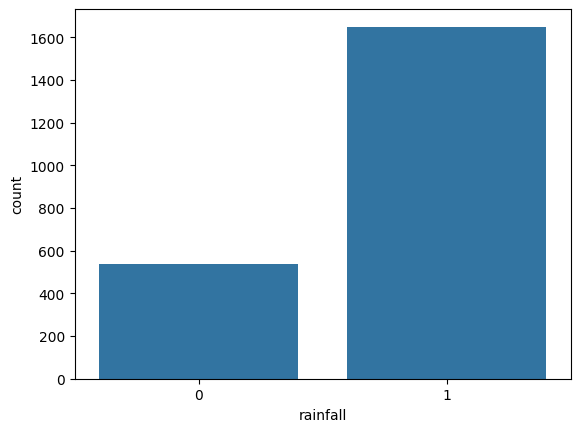

In [12]:
sns.countplot(data = train_df,x = "rainfall")

## **Duplicate**

In [13]:
features = train_df.columns.values[1:12]
features

array(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed'],
      dtype=object)

In [14]:
train_dp = []
test_dp = []
for i in features:
    f = train_df[i].value_counts()
    train_dp.append([i,f.max(),f.idxmax()])
    f = test_df[i].value_counts()
    test_dp.append([i,f.max(),f.idxmax()])
train_dp = pd.DataFrame(train_dp,columns=["feature","dup","value"])
test_dp = pd.DataFrame(test_dp,columns=["feature","dup","value"])

In [15]:
train_dp

,feature,dup,value
0,day,7,112.0
1,pressure,64,1008.1
2,maxtemp,43,31.0
3,temparature,55,30.1
4,mintemp,52,26.8
5,dewpoint,70,25.4
6,humidity,192,79.0
7,cloud,375,88.0
8,sunshine,337,0.0
9,winddirection,273,70.0


In [16]:
test_dp

,feature,dup,value
0,day,2,365.0
1,pressure,23,1008.1
2,maxtemp,25,31.0
3,temparature,16,28.1
4,mintemp,19,24.8
5,dewpoint,34,25.3
6,humidity,61,79.0
7,cloud,134,88.0
8,sunshine,122,0.0
9,winddirection,96,70.0


# **Analysis Data**

## **Raw Data**

array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'pressure'}>,
        <Axes: title={'center': 'maxtemp'}>],
       [<Axes: title={'center': 'temparature'}>,
        <Axes: title={'center': 'mintemp'}>,
        <Axes: title={'center': 'dewpoint'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'cloud'}>,
        <Axes: title={'center': 'sunshine'}>,
        <Axes: title={'center': 'winddirection'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'rainfall'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

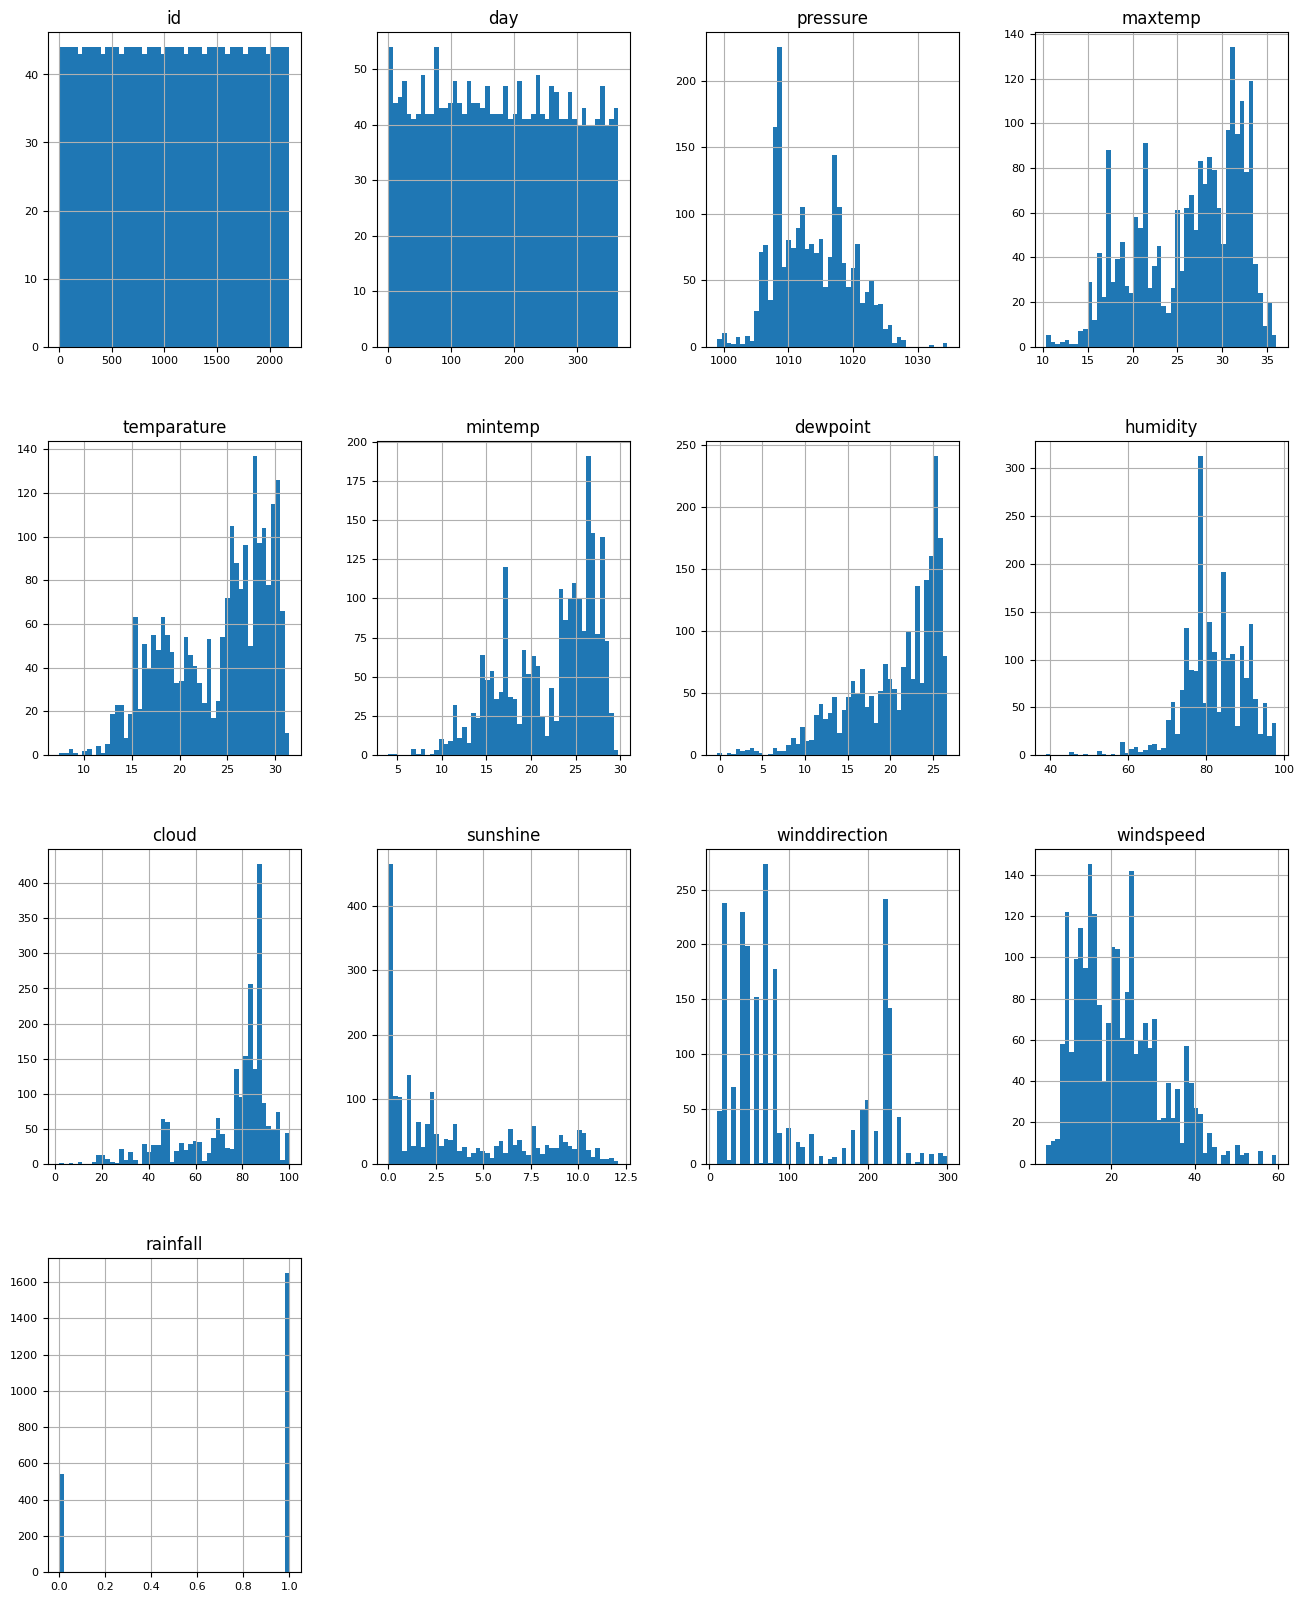

In [17]:
train_df.hist(figsize=(16, 20),bins = 50,xlabelsize=8,ylabelsize=8)

## **Mean**

In [18]:
r0 = train_df[train_df['rainfall'] == 0]
r1 = train_df[train_df['rainfall'] == 1]

<Figure size 640x480 with 0 Axes>

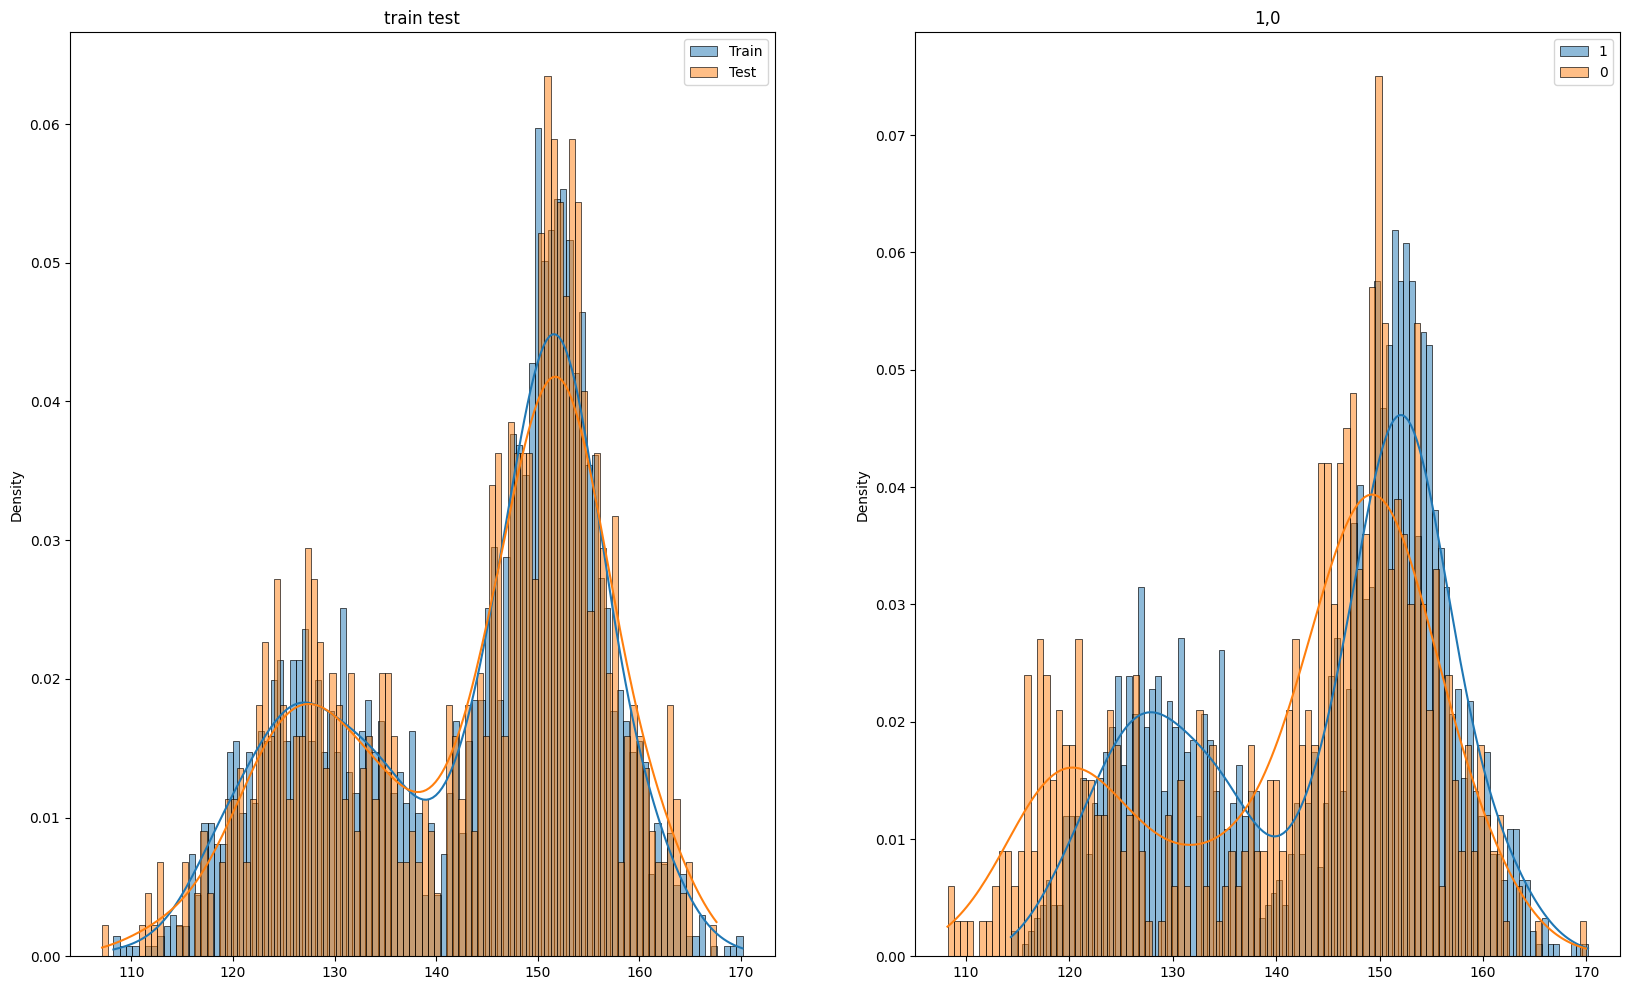

In [19]:
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(20,12))
features = train_df.columns.values[1:12]

plt.subplot(1,2,1)
plt.title("train test")
sns.histplot(data = train_df[features].mean(axis = 1),kde = True,bins = 100,label = "Train",stat = "density")
sns.histplot(data = test_df[features].mean(axis = 1),kde = True,bins = 100,label = "Test",stat = "density")
plt.legend()

plt.subplot(1,2,2)
plt.title("1,0")
sns.histplot(data = r1[features].mean(axis = 1),kde = True,bins = 100,label = "1",stat = "density")
sns.histplot(data = r0[features].mean(axis = 1),kde = True,bins = 100,label = "0",stat = "density")
plt.legend()

## **Standard deviation**

<Figure size 640x480 with 0 Axes>

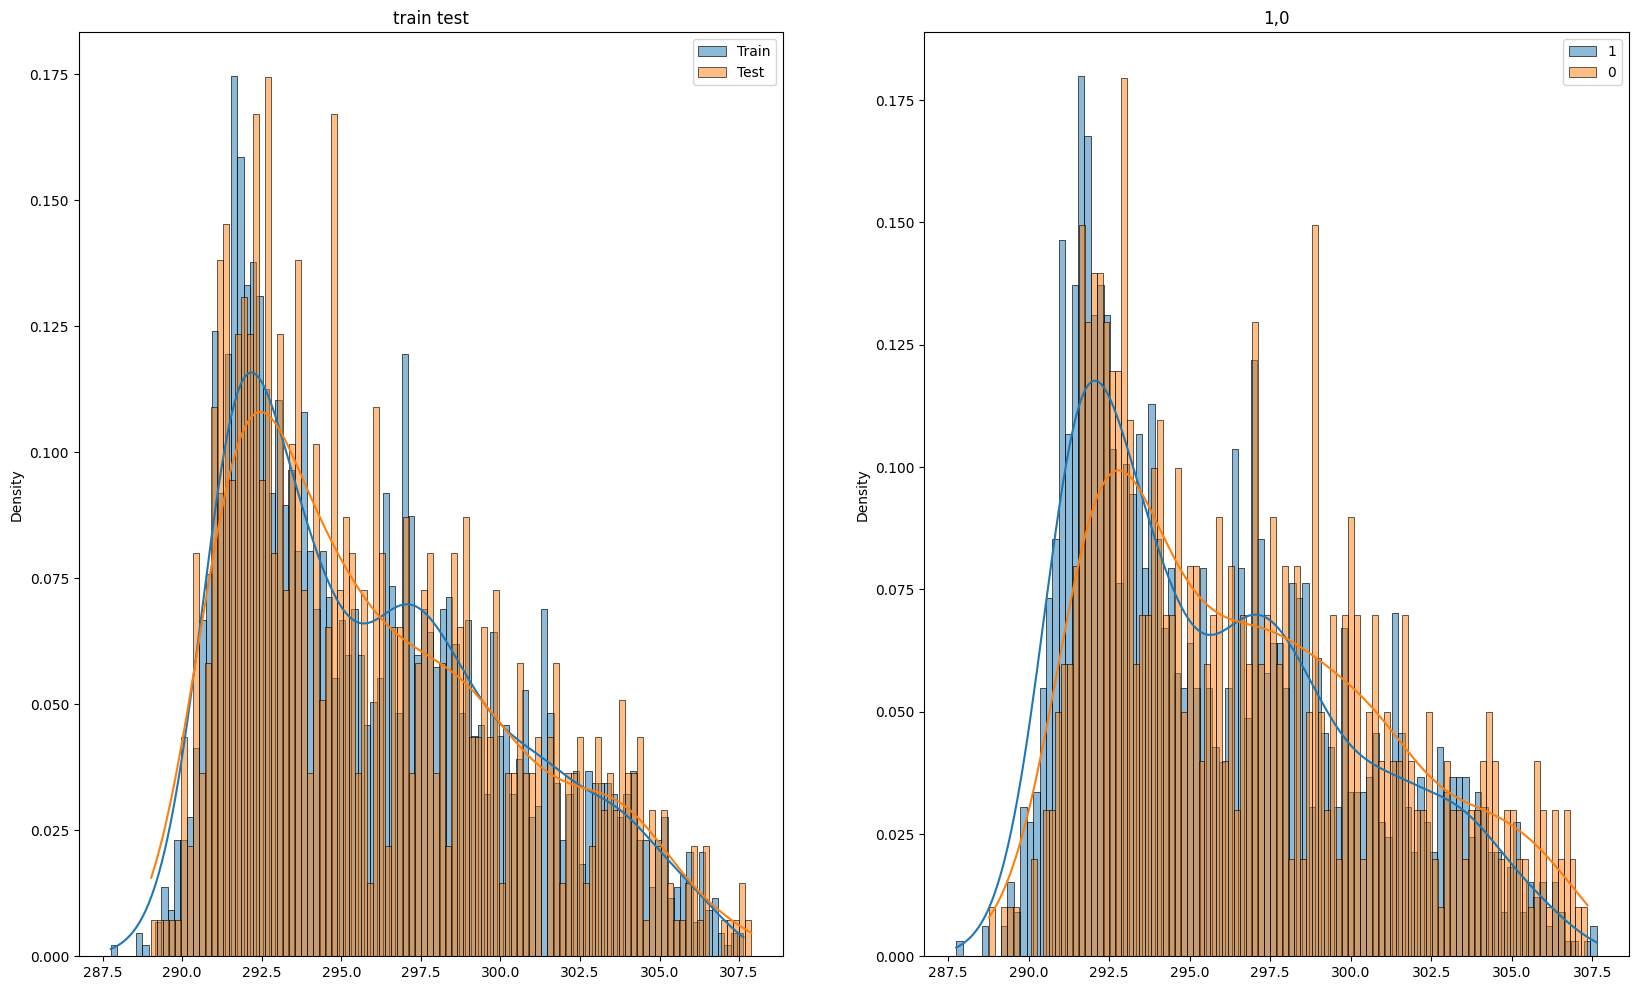

In [20]:
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(20,12))
features = train_df.columns.values[1:12]

plt.subplot(1,2,1)
plt.title("train test")
sns.histplot(data = train_df[features].std(axis = 1),kde = True,bins = 100,label = "Train",stat = "density")
sns.histplot(data = test_df[features].std(axis = 1),kde = True,bins = 100,label = "Test",stat = "density")
plt.legend()

plt.subplot(1,2,2)
plt.title("1,0")
sns.histplot(data = r1[features].std(axis = 1),kde = True,bins = 100,label = "1",stat = "density")
sns.histplot(data = r0[features].std(axis = 1),kde = True,bins = 100,label = "0",stat = "density")
plt.legend()

## **Min**

<Figure size 640x480 with 0 Axes>

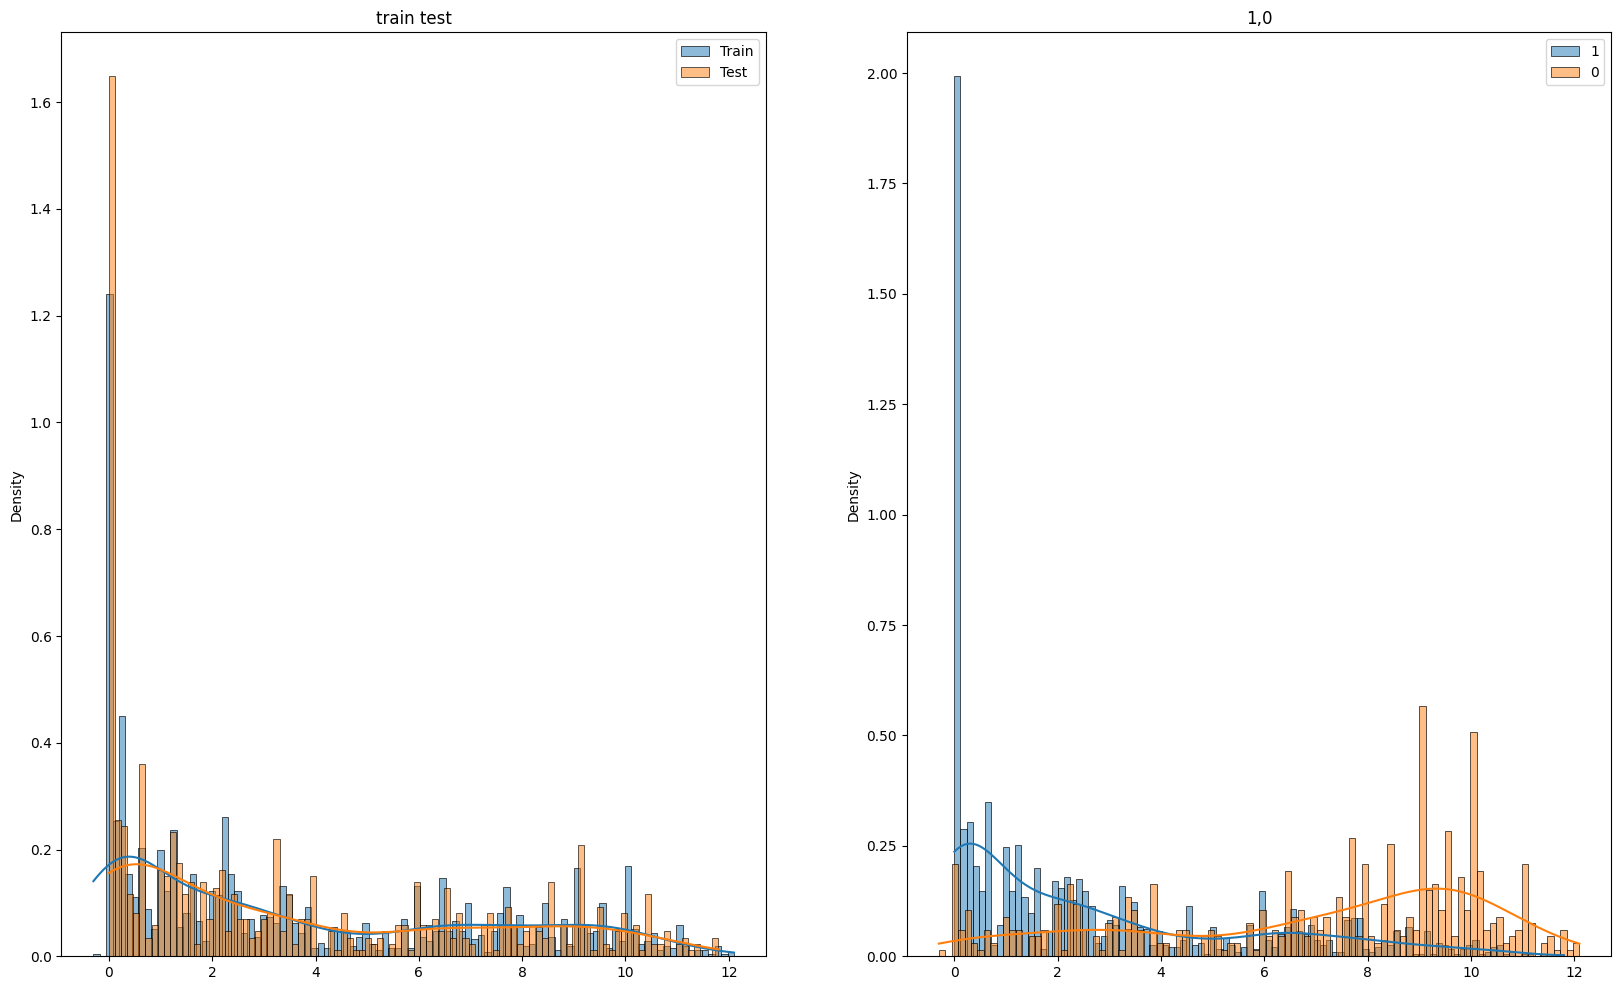

In [21]:
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(20,12))
features = train_df.columns.values[1:12]

plt.subplot(1,2,1)
plt.title("train test")
sns.histplot(data = train_df[features].min(axis = 1),kde = True,bins = 100,label = "Train",stat = "density")
sns.histplot(data = test_df[features].min(axis = 1),kde = True,bins = 100,label = "Test",stat = "density")
plt.legend()

plt.subplot(1,2,2)
plt.title("1,0")
sns.histplot(data = r1[features].min(axis = 1),kde = True,bins = 100,label = "1",stat = "density")
sns.histplot(data = r0[features].min(axis = 1),kde = True,bins = 100,label = "0",stat = "density")
plt.legend()

## **Max**

<Figure size 640x480 with 0 Axes>

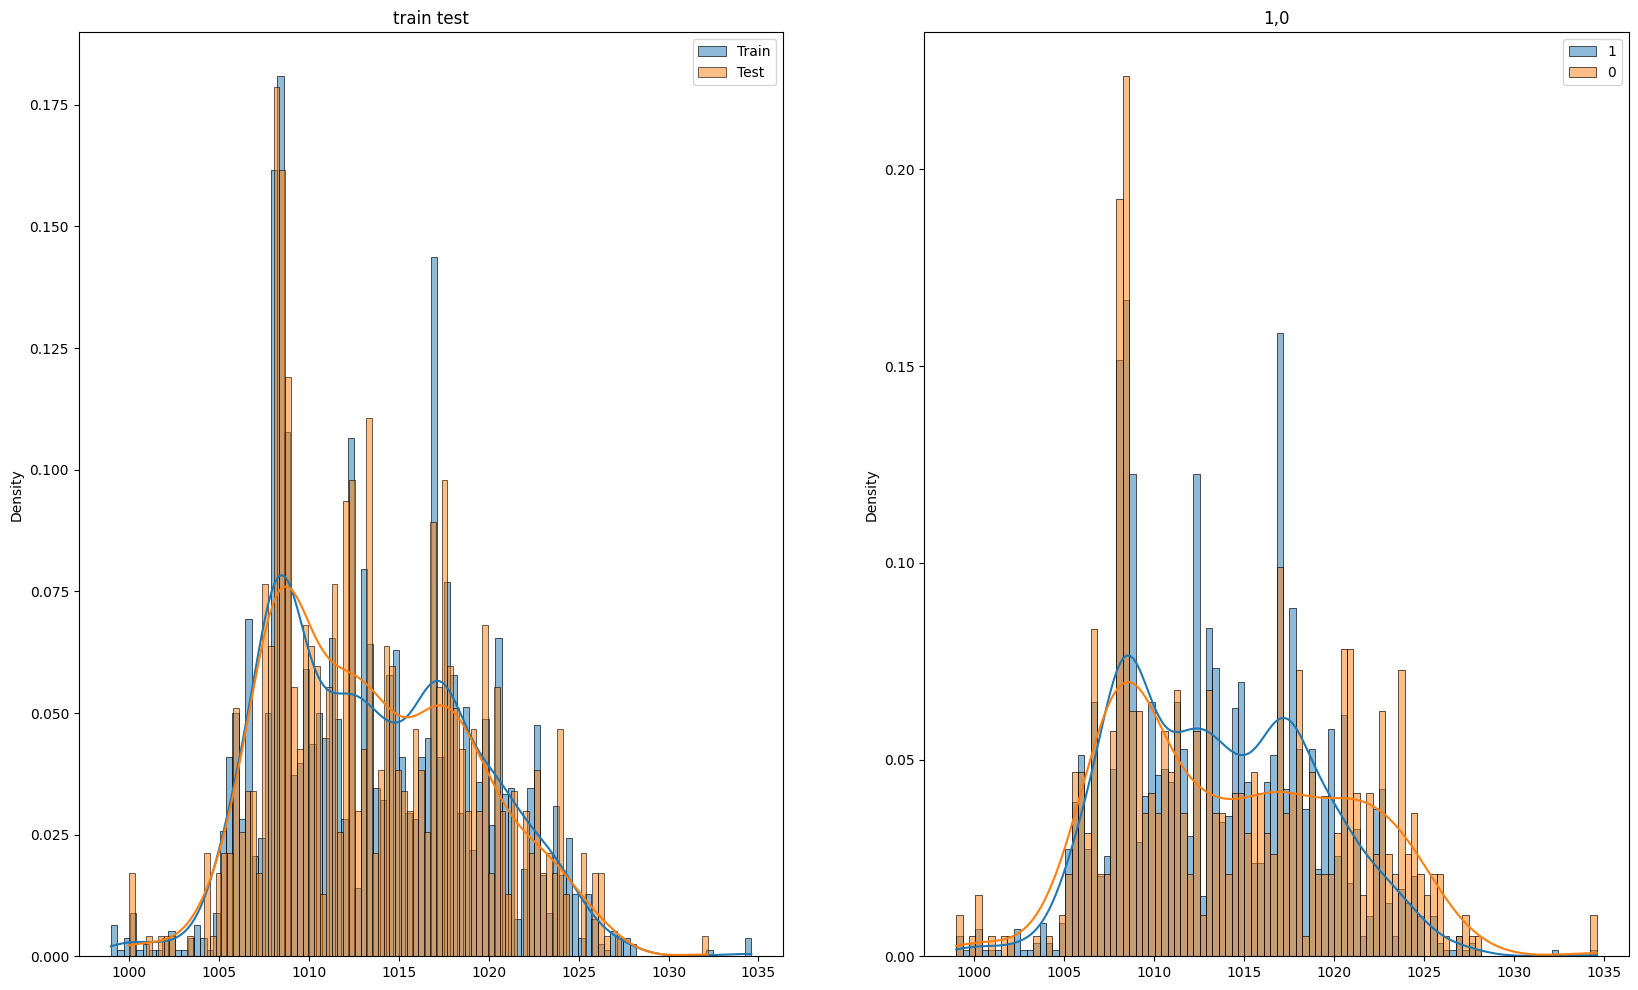

In [22]:
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(20,12))
features = train_df.columns.values[1:12]

plt.subplot(1,2,1)
plt.title("train test")
sns.histplot(data = train_df[features].max(axis = 1),kde = True,bins = 100,label = "Train",stat = "density")
sns.histplot(data = test_df[features].max(axis = 1),kde = True,bins = 100,label = "Test",stat = "density")
plt.legend()

plt.subplot(1,2,2)
plt.title("1,0")
sns.histplot(data = r1[features].max(axis = 1),kde = True,bins = 100,label = "1",stat = "density")
sns.histplot(data = r0[features].max(axis = 1),kde = True,bins = 100,label = "0",stat = "density")
plt.legend()

## **Skew**

<Figure size 640x480 with 0 Axes>

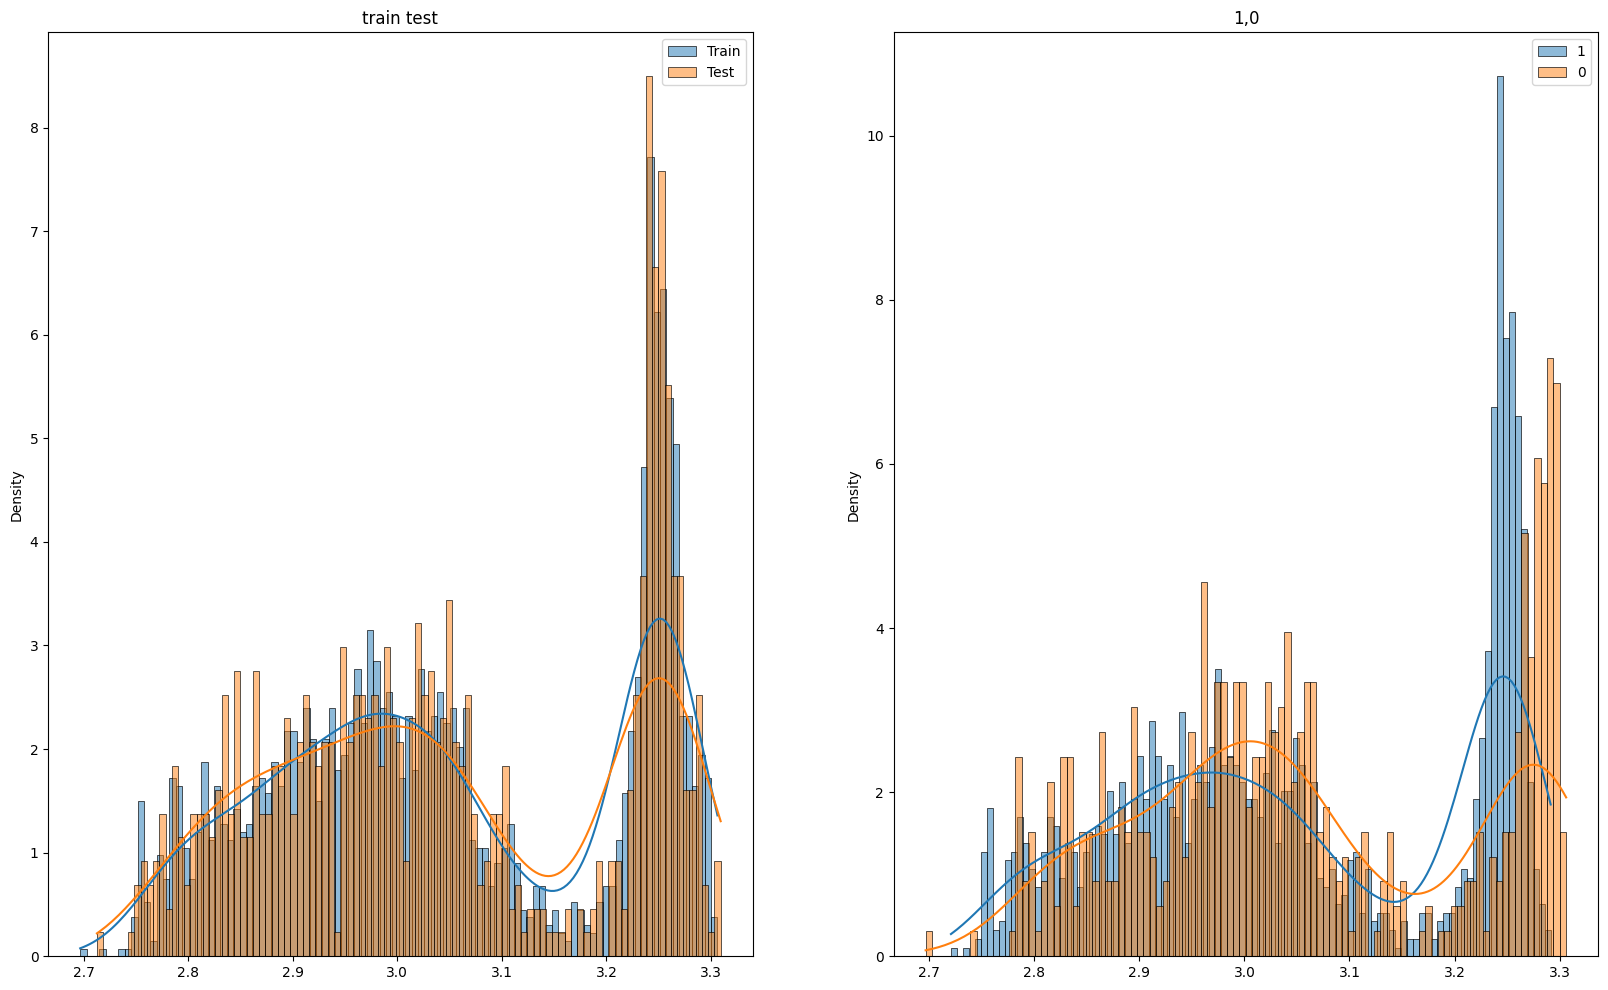

In [23]:
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(20,12))
features = train_df.columns.values[1:12]

plt.subplot(1,2,1)
plt.title("train test")
sns.histplot(data = train_df[features].skew(axis = 1),kde = True,bins = 100,label = "Train",stat = "density")
sns.histplot(data = test_df[features].skew(axis = 1),kde = True,bins = 100,label = "Test",stat = "density")
plt.legend()

plt.subplot(1,2,2)
plt.title("1,0")
sns.histplot(data = r1[features].skew(axis = 1),kde = True,bins = 100,label = "1",stat = "density")
sns.histplot(data = r0[features].skew(axis = 1),kde = True,bins = 100,label = "0",stat = "density")
plt.legend()

## **Kurtosis**

<Figure size 640x480 with 0 Axes>

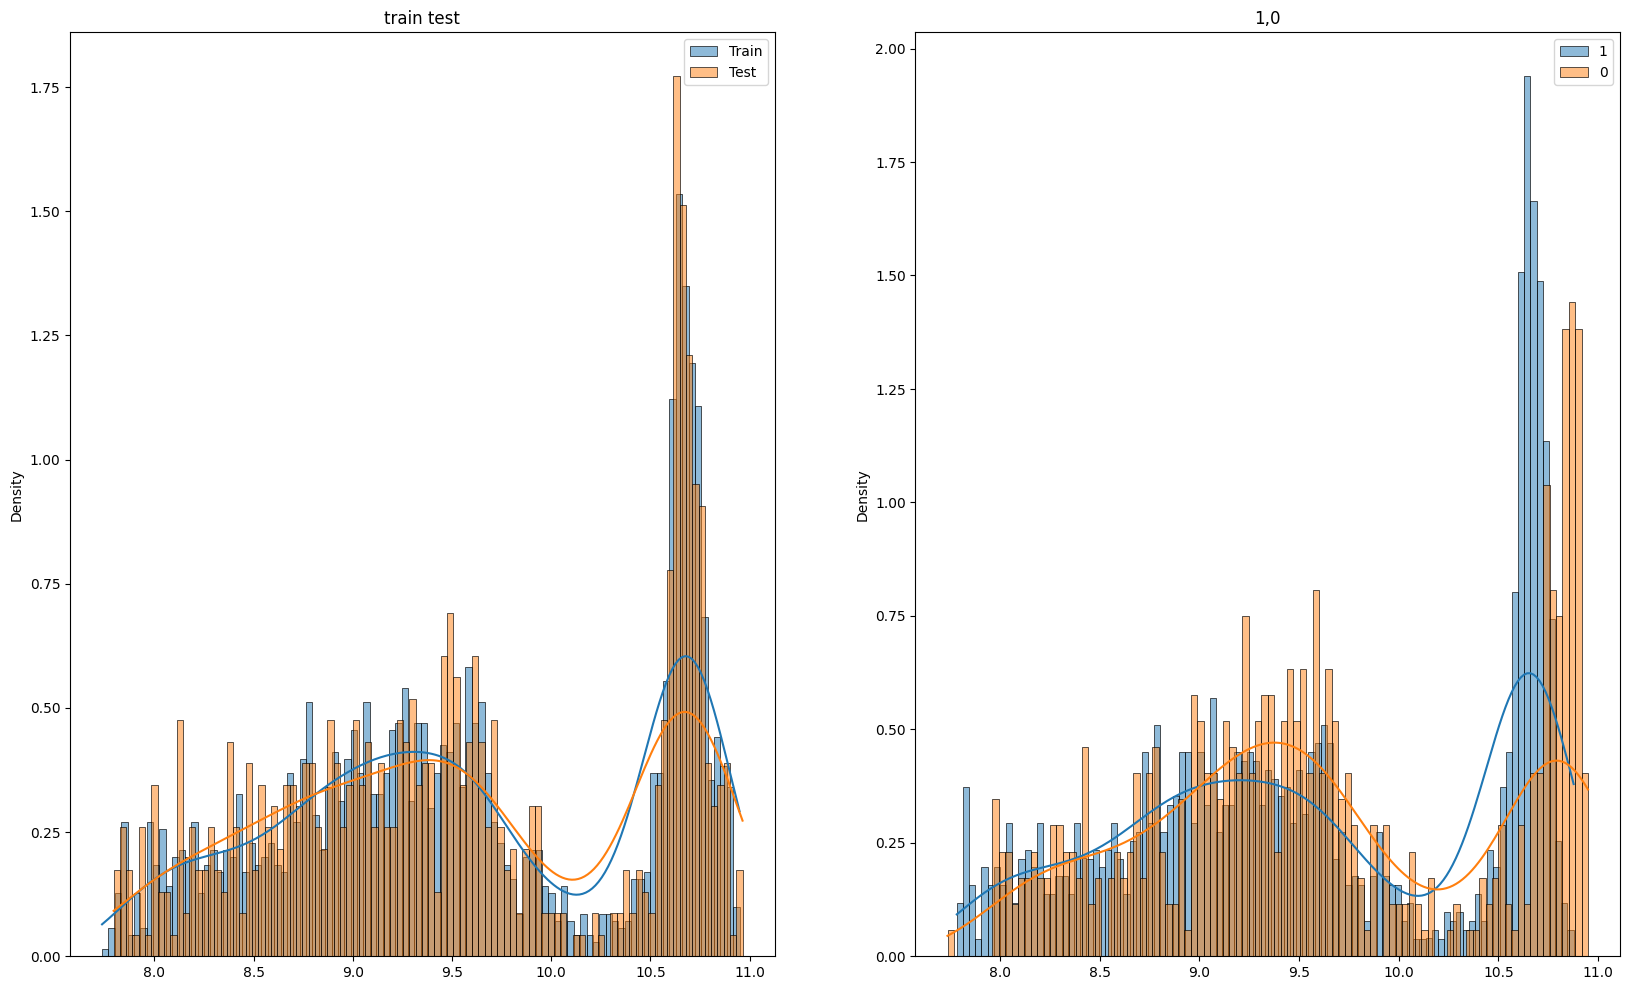

In [24]:
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(20,12))
features = train_df.columns.values[1:12]

plt.subplot(1,2,1)
plt.title("train test")
sns.histplot(data = train_df[features].kurtosis(axis = 1),kde = True,bins = 100,label = "Train",stat = "density")
sns.histplot(data = test_df[features].kurtosis(axis = 1),kde = True,bins = 100,label = "Test",stat = "density")
plt.legend()

plt.subplot(1,2,2)
plt.title("1,0")
sns.histplot(data = r1[features].kurtosis(axis = 1),kde = True,bins = 100,label = "1",stat = "density")
sns.histplot(data = r0[features].kurtosis(axis = 1),kde = True,bins = 100,label = "0",stat = "density")
plt.legend()

## **Sum**

<Figure size 640x480 with 0 Axes>

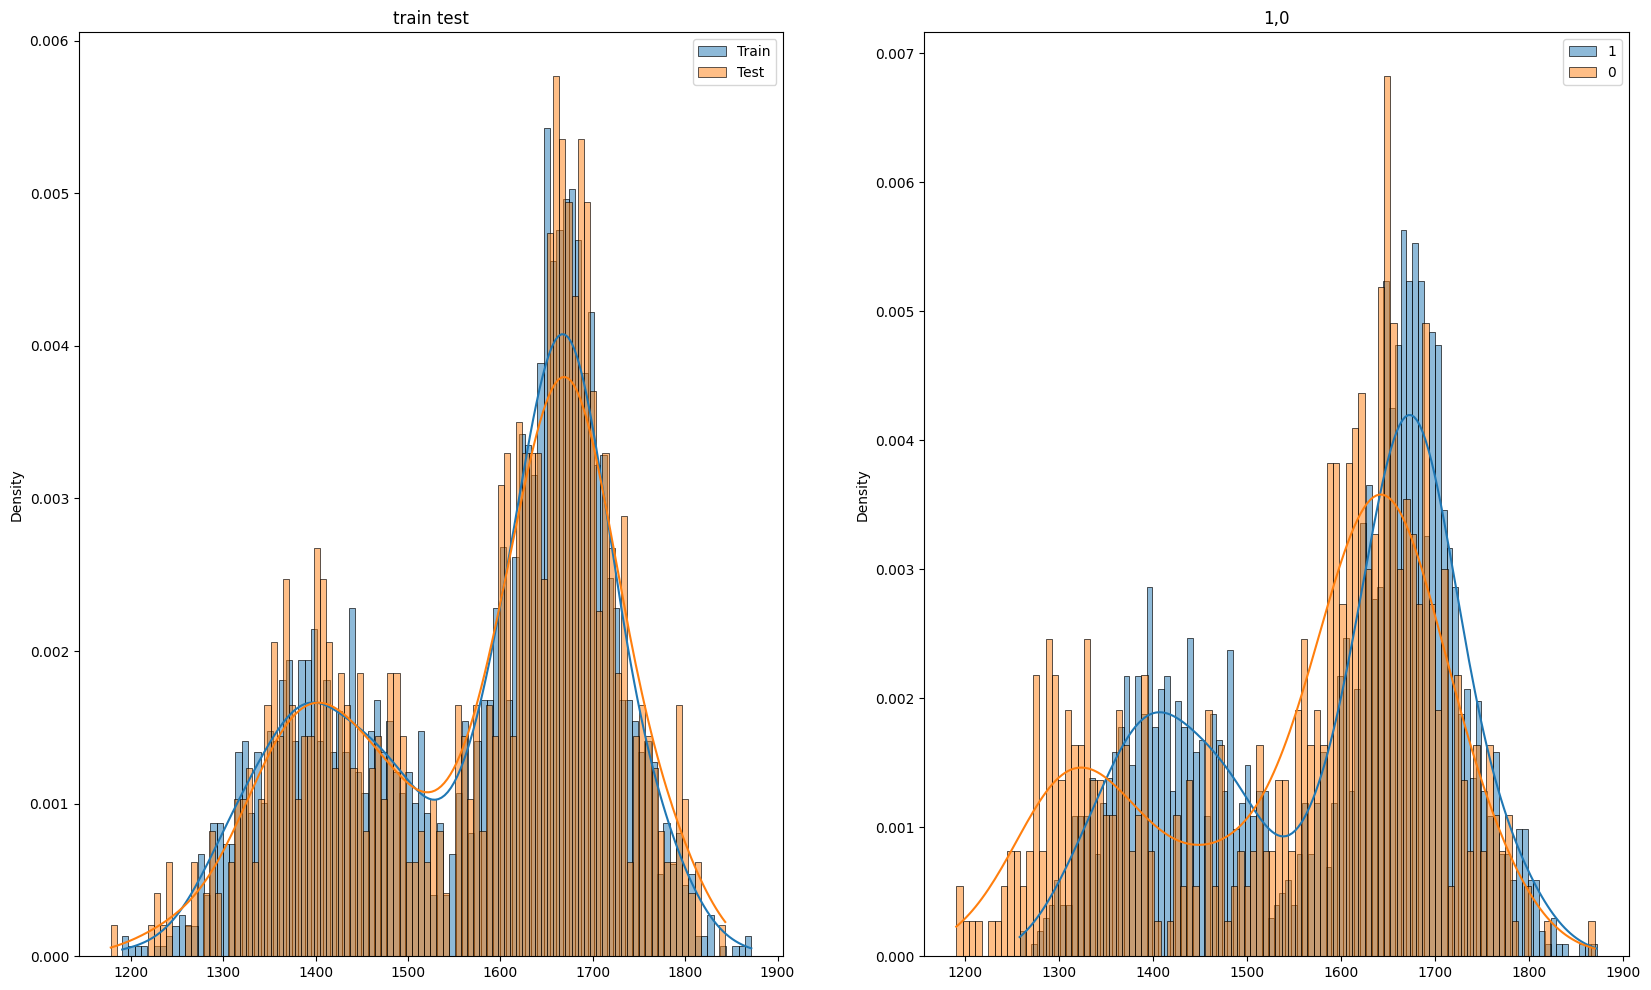

In [25]:
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(20,12))
features = train_df.columns.values[1:12]

plt.subplot(1,2,1)
plt.title("train test")
sns.histplot(data = train_df[features].sum(axis = 1),kde = True,bins = 100,label = "Train",stat = "density")
sns.histplot(data = test_df[features].sum(axis = 1),kde = True,bins = 100,label = "Test",stat = "density")
plt.legend()

plt.subplot(1,2,2)
plt.title("1,0")
sns.histplot(data = r1[features].sum(axis = 1),kde = True,bins = 100,label = "1",stat = "density")
sns.histplot(data = r0[features].sum(axis = 1),kde = True,bins = 100,label = "0",stat = "density")
plt.legend()

## **Correlation**

In [26]:
corr = train_df.corr().abs().unstack().sort_values(kind="quicksort",ascending = False).reset_index()
corr = corr[corr['level_0'] != corr['level_1']]

In [27]:
corr.head(20)

,level_0,level_1,0
13,temparature,mintemp,0.987150
14,mintemp,temparature,0.987150
15,temparature,maxtemp,0.982932
16,maxtemp,temparature,0.982932
17,maxtemp,mintemp,0.965529
18,mintemp,maxtemp,0.965529
19,mintemp,dewpoint,0.941342
20,dewpoint,mintemp,0.941342
21,dewpoint,temparature,0.933617
22,temparature,dewpoint,0.933617


In [28]:
corr.tail(20)

,level_0,level_1,0
149,humidity,mintemp,0.009891
150,mintemp,humidity,0.009891
151,pressure,id,0.008235
152,id,pressure,0.008235
153,rainfall,winddirection,0.006939
154,winddirection,rainfall,0.006939
155,dewpoint,id,0.006797
156,id,dewpoint,0.006797
157,pressure,day,0.005337
158,day,pressure,0.005337


# **Feature Engineering**

In [29]:
def feature_engineer(df):
    df['mean'] = df[features].mean(axis=1)
    df['min'] = df[features].min(axis=1)
    df['skew'] = df[features].skew(axis=1)
    df['sum'] = df[features].sum(axis=1)

In [30]:
for df in train_df,test_df:
    feature_engineer(df)
train_df = train_df.drop(columns=['id','winddirection','day'])
test_df = test_df.drop(columns=['id','winddirection','day'])

In [31]:
train_df.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,rainfall,mean,min,skew,sum
0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,17.2,1,122.981818,1.0,3.252317,1352.8
1,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,21.9,1,122.154545,0.0,3.245235,1343.7
2,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,18.1,1,118.627273,3.0,3.275920,1304.9
3,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,35.6,1,124.781818,0.0,3.240727,1372.6
4,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,24.8,0,114.245455,3.6,3.299465,1256.7


In [32]:
test_df.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,windspeed,mean,min,skew,sum
0,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,24.3,122.790909,0.0,3.237066,1350.7
1,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,35.3,124.063636,0.0,3.237387,1364.7
2,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,16.9,118.700000,0.0,3.245756,1305.7
3,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,50.6,117.018182,4.0,3.285425,1287.2
4,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,19.4,112.127273,4.3,3.290834,1233.4


# **Model**

In [33]:
x = [c for c in train_df.columns if c not in ['rainfall']]
y = 'rainfall'
x,y

(['pressure',
  'maxtemp',
  'temparature',
  'mintemp',
  'dewpoint',
  'humidity',
  'cloud',
  'sunshine',
  'windspeed',
  'mean',
  'min',
  'skew',
  'sum'],
 'rainfall')

In [34]:
df = h2o.H2OFrame(train_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [39]:
df[y] = df[y].asfactor()

In [40]:
aml = H2OAutoML(max_models = 30, max_runtime_secs=3600, seed = 42,verbosity='info',sort_metric='AUC')
aml.train(x = x, y = y, training_frame = df)

AutoML progress: |
06:30:49.281: Project: AutoML_4_20260121_63049
06:30:49.281: 5-fold cross-validation will be used.
06:30:49.283: Setting stopping tolerance adaptively based on the training frame: 0.02136869215853441
06:30:49.283: Build control seed: 42
06:30:49.283: training frame: Frame key: AutoML_4_20260121_63049_training_py_2_sid_bb5f    cols: 14    rows: 2190  chunks: 1    size: 87318  checksum: 2394305780819916300
06:30:49.283: validation frame: NULL
06:30:49.283: leaderboard frame: NULL
06:30:49.283: blending frame: NULL
06:30:49.283: response column: rainfall
06:30:49.283: fold column: null
06:30:49.283: weights column: null
06:30:49.284: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (7g, 10w)]}, {DeepL

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_4_20260121_63049


GLM Model: summary
    family    link    regularization               lambda_search                                                                  number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------  -----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------------------------------------
    binomial  logit   Ridge ( lambda = 0.003239 )  nlambda = 30, lambda.max = 27.63, lambda.min = 0.003239, lambda.1se = 0.03506  13                            13                             40                      AutoML_4_20260121_63049_training_py_2_sid_bb5f

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.10024153707807217
RMSE: 0.31660943933823604
LogLoss: 0.32997383393720653
AUC: 0.8969551066217734
AUCPR: 0.9586697782252689
Gini: 0.7939102132435467
Null degrees of freedom: 2189
Residual degrees of freedom: 2176
Null deviance: 2446.411342434959
Residual deviance: 1445.2853926449645
AIC: 1473.2853926449645

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.596154619666102
       0    1     Error    Rate
-----  ---  ----  -------  --------------
0      380  160   0.2963   (160.0/540.0)
1      123  1527  0.0745   (123.0/1650.0)
Total  503  1687  0.1292   (283.0/2190.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.596155     0.915193  210
max f2                       0.139398     0.949682  352
max f0point5                 0.665695     0.912137  190
max accuracy                 0.596155     0.870776  210
max precision                0.989783     1         0
max recall                   0.0436209    1         388
max specificity              0.989783     1         0
max absolute_mcc             0.596155     0.644699  210
max min_per_class_accuracy   0.808093     0.815758  137
max mean_per_class_accuracy  0.749508     0.824108  160
max tns                      0.989783     540       0
max fns                      0.989783     1646      0
max fps                      0.00252068   540       399
max tps                      0.0436209    1650      388
max tnr                      0.989783     1         0
max fnr                      0.989783     0.997576  0
max fpr                      0.00252068   1         399
max tpr                      0.0436209    1         388

Gains/Lift Table: Avg response rate: 75.34 %, avg score: 75.34 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100457                   0.98393            1.32727   1.32727            1                0.986607  1                           0.986607            0.0133333       0.0133333                  32.7273   32.7273            0.0133333
2        0.0200913                   0.980759           1.32727   1.32727            1                0.982367  1                           0.984487            0.0133333       0.0266667                  32.7273   32.7273            0.0266667
3        0.030137                    0.979286           1.32727   1.32727            1                0.98012   1                           0.983031            0.0133333       0.04                       32.7273   32.7273 

# **Evaluation**

In [41]:
lb = aml.leaderboard
lb.head()
lb.head(rows=lb.nrows) # Entire leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_4_20260121_63049,0.893334,0.334655,0.95635,0.195976,0.318907,0.101702
StackedEnsemble_BestOfFamily_1_AutoML_4_20260121_63049,0.891676,0.333258,0.954493,0.200993,0.316872,0.100408
XGBoost_grid_1_AutoML_4_20260121_63049_model_4,0.890864,0.337327,0.950388,0.187879,0.318541,0.101468
GBM_1_AutoML_4_20260121_63049,0.889296,0.334671,0.952285,0.19197,0.3166,0.100236
StackedEnsemble_AllModels_1_AutoML_4_20260121_63049,0.889205,0.335956,0.94979,0.205,0.317604,0.100872
DeepLearning_grid_2_AutoML_4_20260121_63049_model_2,0.888751,0.344259,0.95404,0.192593,0.321452,0.103332
XGBoost_grid_1_AutoML_4_20260121_63049_model_6,0.888057,0.341161,0.948842,0.20803,0.320898,0.102976
DeepLearning_grid_3_AutoML_4_20260121_63049_model_2,0.887478,0.344198,0.95311,0.193468,0.322506,0.10401
DeepLearning_grid_1_AutoML_4_20260121_63049_model_2,0.88482,0.351229,0.952086,0.202508,0.323774,0.104829
GBM_3_AutoML_4_20260121_63049,0.884725,0.343221,0.948747,0.211162,0.321887,0.103611


AUC: 0.8933338945005611

Confusion Matrix:
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5597678337006018
       0    1     Error    Rate
-----  ---  ----  -------  --------------
0      365  175   0.3241   (175.0/540.0)
1      112  1538  0.0679   (112.0/1650.0)
Total  477  1713  0.1311   (287.0/2190.0)


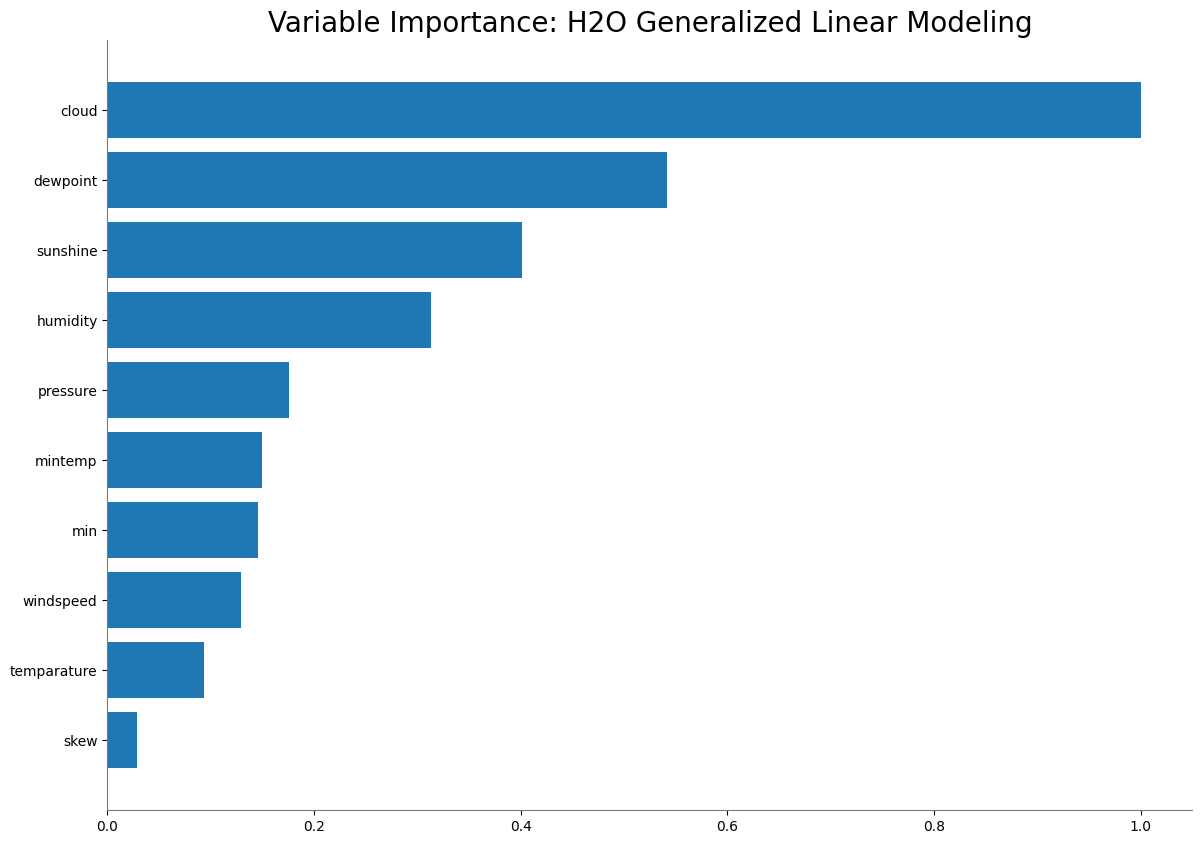

<Figure size 640x480 with 0 Axes>

In [42]:
best_model = aml.leader
perf = best_model.model_performance(xval=True)
print("AUC:", perf.auc())
print("\nConfusion Matrix:")
print(perf.confusion_matrix())
try:
    best_model.varimp_plot()
except:
    print("This model type doesn't support variable importance plot")

# **Submission**

In [43]:
test_df = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [44]:
preds = aml.predict(test_df)
preds_df = h2o.as_list(preds)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [45]:
sub_df = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub_df

,id,rainfall
0,2190,0
1,2191,0
2,2192,0
3,2193,0
4,2194,0
...,...,...
725,2915,0
726,2916,0
727,2917,0
728,2918,0


In [46]:
sub = pd.DataFrame({
    'id':sub_df['id'],
    'rainfall':preds_df['p1']
})

In [47]:
sub.head()

,id,rainfall
0,2190,0.978804
1,2191,0.982777
2,2192,0.923130
3,2193,0.142272
4,2194,0.057747


In [48]:
sub.to_csv('submission.csv', index=False)